**Imprint of extreme El Nino event on global mean sea level change over 2014-2016**  
**kevin.balem@ifremer.fr**

In this study, we investigate the extreme El Nino event occurring in 2015-2016 and its imprint on the global mean sea level change by assessing all the different components of the sea level budget. Over 2014-2016, we find that the global mean sea level experiences a rise of 1.5 cm over 24 months. 25% of this rise can be attributed to global ocean warming and 75% to the imports of continental ice melt. We then assess a complete continental freshwater budget (Greenland, Antarctica and terrestrial water storage) to quantify this extreme El Nino event and its imprint on global mean sea level rise.

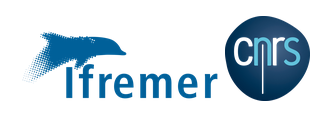

In [41]:
import xarray as xr
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
from sklearn import preprocessing
from scipy import signal
from scipy import interpolate
import numpy as np
import pandas as pd
import cartopy
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
cartopy.config['pre_existing_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['repo_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import calendar
plt.rcParams['figure.figsize'] = (15, 5)
pr1 = ccrs.PlateCarree()
pr2 = ccrs.Robinson()

In [2]:
# Big scale 
t1 = np.datetime64('2006-02-01')
t2 = np.datetime64('2017-06-01')
# Fine scale
t3 = np.datetime64('2014-06-15')
t4 = np.datetime64('2016-05-15')
# Parameters for smoothing (4 time steps for altimetry, which is already 2M smoothed, 8 for others)
window_gmsl=4
window=8

To set our temporal domain, let's check the SOI, data from https://www.cpc.ncep.noaa.gov/data/indices/soi

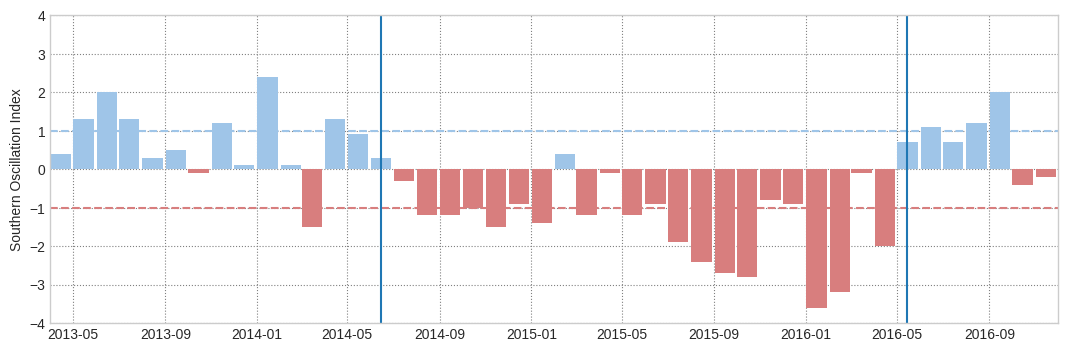

In [3]:
soi = xr.open_dataset('soi.nc')
soi = soi.dropna('TSAXIS')
positive_color = '#9fc5e8'
negative_color = '#d87e7e'
col = np.empty_like(soi['SOI'].values,dtype='U7')
col[soi['SOI']>0] = positive_color
col[soi['SOI']<=0] = negative_color

f,ax=plt.subplots(figsize=(13,4))
ax.bar(soi['TSAXIS'],soi['SOI'],width=27.,color=col, align='center')
#soi['SOI'].rolling(TSAXIS=3,center=True).mean().plot.line('k',linewidth=1,label='6 months mean')
ax.set_xlim(np.datetime64('2013-04'),np.datetime64('2016-12'))
ax.grid(linestyle=':',color='gray')
ax.set_ylabel('Southern Oscillation Index')
ax.set_ylim([-4,4])
ax.axhline(1,linestyle='--',color=positive_color)
ax.axhline(-1,linestyle='--',color=negative_color)
ax.axvline(t3)
ax.axvline(t4)
#plt.savefig('figure_papier/soi_2013-2016.png',dpi=300)

In [4]:
def shz(da,t=t3,window=8):
    return ((da.groupby('time.month')-da.groupby('time.month').mean()).rolling(time=window,center=True).mean()) -\
           ((da.groupby('time.month')-da.groupby('time.month').mean()).rolling(time=window,center=True).mean()).interp(time=t)

# Altimetry

https://www.aviso.altimetry.fr/en/data/products/ocean-indicators-products/mean-sea-level/data-acces.html#c12195   
GMSL timeseries for reference missions (TopEx-Poseidon, Jason-1,-2,-3, Sentinel-6MF) and auxiliary missions (Saral/Altika, ERS-1,-2, Envisat, GFO)   
Here we use the MERGED missions product, GIA not corrected, 2 months smoothed

In [5]:
gmsl = xr.open_dataset('/home/datawork-lops-oh/SEA_LEVEL_CHANGE/MSL-AVISO/MSL_Serie_MERGED_Global_AVISO_GIA_NoAdjust_Filter2m.nc')
# Uncertainty in mm
gmsl_error = 2.6
gmsl = gmsl['msl']
gmsl = gmsl.where((gmsl.time>=t1)&(gmsl.time<t2),drop=True)
# Product is at 10 days, let's resample monthly
gmsl = gmsl.resample(time='1M').mean()

/export/home/anaconda3/envs/test_argopy/lib/python3.7/site-packages/xarray/core/common.py:1124: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset


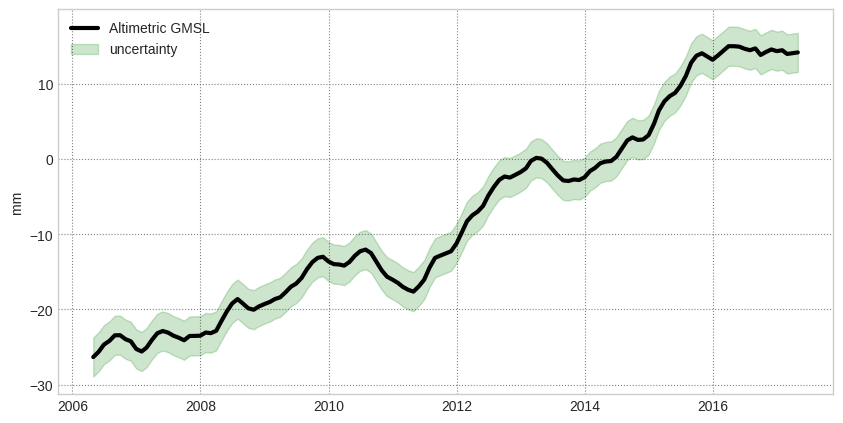

In [6]:
# Plot
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(gmsl.time,1e3*shz(gmsl,window=4),'k',label='Altimetric GMSL',linewidth=3)

ax.fill_between(gmsl.time,
                1e3*shz(gmsl,window=4)-gmsl_error,
                1e3*shz(gmsl,window=4)+gmsl_error,
                color='green',alpha=0.2,label='uncertainty')

ax.grid(linestyle=':',color='gray')
ax.set_ylabel('mm')
plt.legend()

# Grace TWS, scaled with gain factors (greeland/antarctic removed)

https://grace.jpl.nasa.gov/data/get-data/monthly-mass-grids-land/   

**Monthly mass grids - Land**  
About **Grid Scaling**    
Due to the sampling and post-processing of GRACE observations, surface mass variations at small spatial scales tend to be attenuated. Therefore, USERS SHOULD MULTIPLY THE GRCTellus LAND DATA BY THE PROVIDED SCALING GRID. The scaling grid is a set of scaling coefficients, one for each 1 degree bin of the land grids, and are intended to restore much of the energy removed by the destriping, gaussian, and degree 60 filters to the land grids. To use these scaling coefficients, the time series at one grid (1 degree bin) location must be multiplied by the scaling factor at the same 1 degree bin position.   
   
Here we compute the mean TWS from CSR, GFZ and JPL product

In [7]:
gland1 = xr.open_mfdataset('/home/datawork-lops-oh/SEA_LEVEL_CHANGE/GRACE/CSR/*.nc')
gland2 = xr.open_mfdataset('/home/datawork-lops-oh/SEA_LEVEL_CHANGE/GRACE/GFZ/*.nc')
gland3 = xr.open_mfdataset('/home/datawork-lops-oh/SEA_LEVEL_CHANGE/GRACE/JPL/*.nc')
# lon -180/180
gland1['lon'].values[gland1['lon'].values>180] -= 360 
gland1 = gland1.sortby(['lon','lat','time'])
gland2['lon'].values[gland2['lon'].values>180] -= 360 
gland2 = gland2.sortby(['lon','lat','time'])
gland3['lon'].values[gland3['lon'].values>180] -= 360 
gland3 = gland3.sortby(['lon','lat','time'])
# Big Scales
#ptime=np.arange('2006-02-15','2017-04-15',dtype='datetime64[M]').astype('datetime64')
gland1 = gland1.where((gland1.time >= t1)&(gland1.time <= t2),drop=True)
gland2 = gland2.where((gland2.time >= t1)&(gland2.time <= t2),drop=True)
gland3 = gland3.where((gland3.time >= t1)&(gland3.time <= t2),drop=True)

# weights
coslat_grace = np.cos(np.deg2rad(gland1.lat)).where(~gland1.lwe_thickness.isnull())
weights_grace = coslat_grace / coslat_grace.sum(dim=('lat', 'lon'))

Then we load the gain factors and apply them

In [8]:
# Gain factors
msc_gridr = xr.open_dataset('/home/datawork-lops-oh/SEA_LEVEL_CHANGE/GRACE/MASCON/JPL/CLM4.SCALE_FACTOR.JPL.MSCNv02CRI.nc')
msc_gridr['lon'].values[msc_gridr['lon'].values>180] -= 360 
msc_gridr = msc_gridr.sortby(['lon','lat'])
# interp grid on tws grid (gain factors are at 0.5°)
msc_grid = msc_gridr.interp(lon=gland1.lon,lat=gland1.lat,method='nearest')

gland1['lwe_thickness_scaled'] = gland1['lwe_thickness'] * msc_grid['scale_factor'].expand_dims(dim={'time':gland1.time},axis=0)
gland2['lwe_thickness_scaled'] = gland2['lwe_thickness'] * msc_grid['scale_factor'].expand_dims(dim={'time':gland2.time},axis=0)
gland3['lwe_thickness_scaled'] = gland3['lwe_thickness'] * msc_grid['scale_factor'].expand_dims(dim={'time':gland3.time},axis=0)

Let's compute the weigted mean time serie and the mean of the 3 solutions (in a DataArray)

In [9]:
# Weighted mean
gracel_weighted1 = -1*(gland1['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load()
gracel_weighted2 = -1*(gland2['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load().interp(time=gracel_weighted1.time)
gracel_weighted3 = -1*(gland3['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load().interp(time=gracel_weighted1.time)
grace_weighted = xr.DataArray(np.mean([gracel_weighted1,gracel_weighted2,gracel_weighted3],axis=0), dims=["time"],coords=dict(time=gracel_weighted1.time))

# Mascon solutions for greenland/antarctic
see : https://grace.jpl.nasa.gov/data/get-data/monthly-mass-grids-land/
> The GRCTellus Land grids processed from the Spherical Harmonic Level-2 data (as described on this page here) are not suited to accurately quantify ice mass changes over Greenland or Antarctica, or glaciers and ice caps. These regions require region-specific averaging kernels, as well as proper treatment of signal contamination from nearby land hydrology and adjusted GIA effects. We recommend the paper by Jacob et al. (2012), for a thorough discussion of these aspects.
To assess land ice mass changes, we recommend JPL's mascon solution (please be sure to read the corresponding documentation).

He we use JPL mascon solution for greenland/antarctic : https://grace.jpl.nasa.gov/data/get-data/jpl_global_mascons/

In [10]:
# LAND MASK
msc_mask = xr.open_dataset('/home/datawork-lops-oh/SEA_LEVEL_CHANGE/GRACE/MASCON/JPL/LAND_MASK.CRI.nc')
msc_mask['lon'].values[msc_mask['lon'].values>180] -= 360 
msc_mask = msc_mask.sortby(['lon','lat'])

In [11]:
# LOAD DATA
msc_jpl = xr.open_dataset('/home/datawork-lops-oh/SEA_LEVEL_CHANGE/GRACE/MASCON/JPL/GRCTellus.JPL.200204_202205.GLO.RL06M.MSCNv02CRI.nc')
msc_jpl['lon'].values[msc_jpl['lon'].values>180] -= 360 
msc_jpl = msc_jpl.sortby(['lon','lat'])
# Big scale
ptime=np.arange('2006-02-15','2017-04-15',dtype='datetime64[M]').astype('datetime64')
msc_jpl = msc_jpl.where((msc_jpl.time >= t1)&(msc_jpl.time <= t2),drop=True)#.interp(time=ptime)
# weights
coslat_jpl = np.cos(np.deg2rad(msc_jpl.lat)).where(~msc_jpl.lwe_thickness.isnull())
weights_jpl = coslat_jpl / coslat_jpl.sum(dim=('lat', 'lon'))

Let's apply the land mask to mascon data, and reduce to greenland/antarctic

In [12]:
msc_jpl = msc_jpl['lwe_thickness'].where(msc_mask==1,drop=False)
msc_jpl = msc_jpl.rename({'land_mask':'lwe_thickness'})
# keep poles
msc_jpl_pole = msc_jpl.where((msc_jpl['lat']<-60)|((msc_jpl.lat>30)&(msc_jpl.lat>60)&(msc_jpl.lon>-90)&(msc_jpl.lon<0)),drop=False)
msc_jpl_pole2 = msc_jpl.where(msc_gridr.scale_factor.isnull())

Compute weigted mean time serie

In [13]:
msc_jpl_weighted = -1*(msc_jpl_pole['lwe_thickness'] * weights_jpl).sum(dim=('lat', 'lon')).load()
msc_jpl_weighted2 = -1*(msc_jpl_pole2['lwe_thickness'] * weights_jpl).sum(dim=('lat', 'lon')).load()

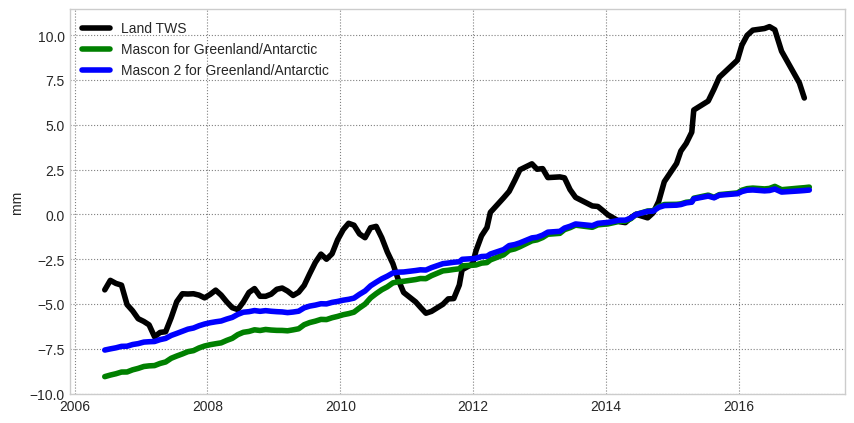

In [14]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

ax.plot(grace_weighted.time,1e3*shz(grace_weighted),'k',label='Land TWS ',linewidth=4)
ax.plot(msc_jpl_weighted.time,10*shz(msc_jpl_weighted),'g',label='Mascon for Greenland/Antarctic',linewidth=4)
ax.plot(msc_jpl_weighted2.time,10*shz(msc_jpl_weighted2),'b',label='Mascon 2 for Greenland/Antarctic',linewidth=4)

ax.grid(linestyle=':',color='gray')
ax.set_ylabel('mm')
plt.legend()

# Grace Ocean Mass

### Spherical Harmonic solution

https://podaac.jpl.nasa.gov/dataset/HOMAGE_GGFO_L4_GOMA_Monthly_v01

This data set contains the monthly Global Ocean Mass Anomalies (goma) since 04/2002, as measured by the GRACE and GRACE Follow-On (G/GFO) satellite missions. The data are averaged over the global ocean domain, at monthly intervals (note: data gaps exist). This file contains the goma time series based on the spherical harmonic gravity fields provided by the G/GFO SDS centers: JPL, CSR, GFZ. The data are frequently updated as new monthly observations are acquired by the GFO mission. The processing of the spherical harmonics gravity field coefficients is as follows: (1) GAD + GSM: the monthly de-aliasing product GAD is added back to the GSM L2 gravity fields; (2) [GSM + GAD] coefficients are averaged over the global ocean with a coastal buffer of 300 km (to avoid land-ocean leakage); (3) the spatial mean of atmospheric loading of the entire global ocean domain is removed (via the GAA L2 data product). A GIA correction using the ICE-6GD model (Peltier et al., 2018) is applied.

In [15]:
goma = xr.open_dataset('goma_GGFO_MM_SHC_200204-202209_v01.nc')
ptime=np.arange('2002-05-15','2022-09-15',dtype='datetime64[M]')
goma_mean = xr.DataArray(np.mean([goma['goma_JPL'].interp(time_JPL=ptime),goma['goma_GFZ'].interp(time_GFZ=ptime),goma['goma_CSR'].interp(time_CSR=ptime)],axis=0), 
                         dims=["time"],coords=dict(time=ptime))
goma_std = xr.DataArray(np.std([goma['goma_JPL'].interp(time_JPL=ptime),goma['goma_GFZ'].interp(time_GFZ=ptime),goma['goma_CSR'].interp(time_CSR=ptime)],axis=0), 
                         dims=["time"],coords=dict(time=ptime))

goma_mean = goma_mean.where((goma_mean.time >= t1)&(goma_mean.time <= t2),drop=True)
goma_std = goma_std.where((goma_std.time >= t1)&(goma_std.time <= t2),drop=True)

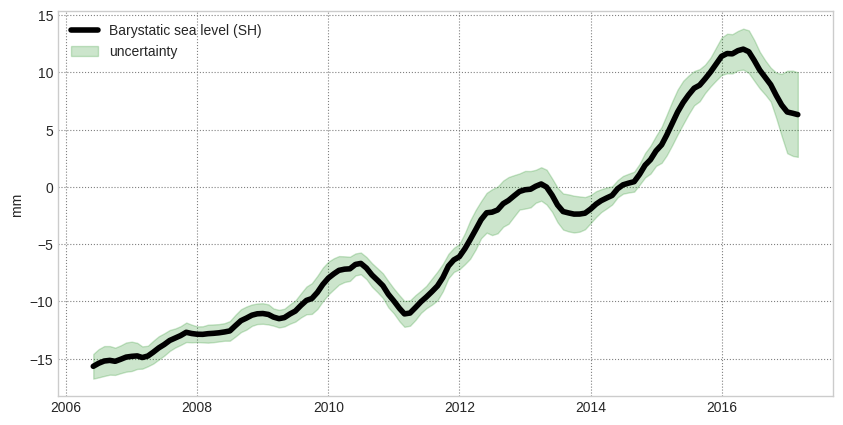

In [16]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

ax.plot(goma_mean.time,shz(goma_mean),
        'k',
        label='Barystatic sea level (SH)',
        linewidth=4)

ax.fill_between(goma_mean.time,
                shz(goma_mean) - 2*np.abs(goma_std.rolling(time=window,center=True).mean()),
                shz(goma_mean) + 2*np.abs(goma_std.rolling(time=window,center=True).mean()),
                color='green',alpha=0.2,label='uncertainty')

ax.grid(linestyle=':',color='gray')
ax.set_ylabel('mm')
plt.legend()

### Mascon solution

https://podaac.jpl.nasa.gov/dataset/OCEAN_MASS_TELLUS_MASCON_CRI_TIME_SERIES_RL06.1_V3

This dataset is a time series of mass variability averaged over all of the global ocean. It provides the non-steric or mass only sea level changes over time. The mass variability are derived from JPL GRACE Mascon Ocean, Ice, and Hydrology Equivalent Water Height CRI Filtered RL06.1Mv03 dataset, which can be found at https://podaac.jpl.nasa.gov/dataset/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3. A more detailed description on the Mascon solution, including the mathematical derivation, implementation of geophysical constraints, and solution validation, please see Watkins et al., 2015, doi: 10.1002/2014JB011547

In [17]:
def gen_time(number):
    year = int(number)
    d = timedelta(days=(number - year)*(365 + calendar.isleap(year)))
    day_one = datetime(year,1,1)
    date = d + day_one
    return date

In [18]:
# READ ASCII DATA
msc_ocean = pd.read_csv('ocean_mass_200204_202211.txt',header=35)
# DECIMAL YEARS TO DATETIME
msc_ocean['time'] = msc_ocean.DECY.apply(lambda x: gen_time(x))
# TO XARRAY
msc_ocean = msc_ocean.set_index('time').to_xarray()
# BIG SCALE
msc_ocean = msc_ocean.where((msc_ocean.time >= t1)&(msc_ocean.time <= t2),drop=True)

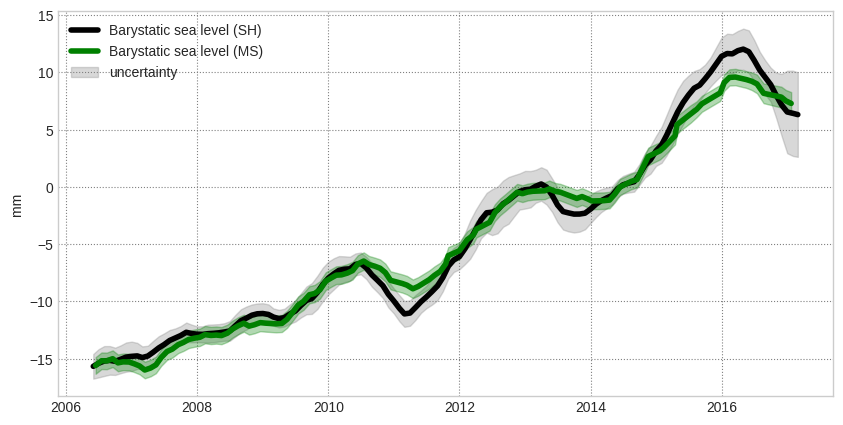

In [19]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

ax.plot(goma_mean.time,shz(goma_mean),
        'k',
        label='Barystatic sea level (SH)',
        linewidth=4)

ax.plot(msc_ocean.time,shz(msc_ocean['MM']),
        'g',
        label='Barystatic sea level (MS)',
        linewidth=4)

ax.fill_between(goma_mean.time,
                shz(goma_mean) - 2*np.abs(goma_std.rolling(time=window,center=True).mean()),
                shz(goma_mean) + 2*np.abs(goma_std.rolling(time=window,center=True).mean()),
                color='gray',alpha=0.3,label='uncertainty')

ax.fill_between(msc_ocean.time,
                shz(msc_ocean['MM']) - 2*msc_ocean['UN'].rolling(time=window,center=True).mean(),
                shz(msc_ocean['MM']) + 2*msc_ocean['UN'].rolling(time=window,center=True).mean(),
                color='g',alpha=0.3)

ax.grid(linestyle=':',color='gray')
ax.set_ylabel('mm')
plt.legend()

# Compare TWS-ESL+Mascon G/A and GOMA

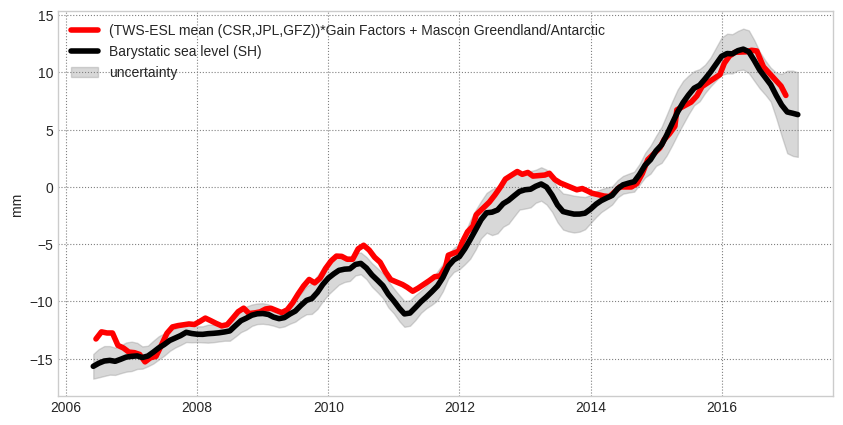

In [20]:
plt.rcParams["axes.axisbelow"] = True
fig,ax=plt.subplots(1,1,figsize=(10,5))

ax.plot(grace_weighted.time,1e3*shz(grace_weighted).values + 10*shz(msc_jpl_weighted).values,
        'red',
        label='(TWS-ESL mean (CSR,JPL,GFZ))*Gain Factors + Mascon Greendland/Antarctic',
        linewidth=4)

ax.plot(goma_mean.time,shz(goma_mean),
        'k',
        label='Barystatic sea level (SH)',
        linewidth=4)

ax.fill_between(goma_mean.time,
                shz(goma_mean) - 2*np.abs(goma_std.rolling(time=window,center=True).mean()),
                shz(goma_mean) + 2*np.abs(goma_std.rolling(time=window,center=True).mean()),
                color='gray',alpha=0.3,label='uncertainty')

ax.grid(linestyle=':',color='gray')
ax.set_ylabel('mm')
plt.legend()

#plt.savefig('figure_papier/compare_goma-tws-masconGA.png',dpi=300)

# Thermosteric

In [21]:
# Steric
steric_g = xr.open_dataset('/home/datawork-lops-oh/SEA_LEVEL_CHANGE/STERIC/GOURETSKI_SSH_thermosteric_0_2000m_Global.nc')
steric_j = xr.open_dataset('/home/datawork-lops-oh/SEA_LEVEL_CHANGE/STERIC/JAMSTEC_SSH_thermosteric_0_2000m_Global.nc')
steric_s = xr.open_dataset('/home/datawork-lops-oh/SEA_LEVEL_CHANGE/STERIC/SCRIPPS_SSH_thermosteric_0_2000m_Global.nc')
steric_i = xr.open_dataset('/home/datawork-lops-oh/SEA_LEVEL_CHANGE/STERIC/IFREMER_ISAS20_SSH_thermosteric_0_2000m_Global.nc')

steric_g = steric_g.where((steric_g.time>=t1)&(steric_g.time<=t2),drop=True)
steric_j = steric_j.where((steric_j.time>=t1)&(steric_j.time<=t2),drop=True)
steric_s = steric_s.where((steric_s.time>=t1)&(steric_s.time<=t2),drop=True)
steric_i = steric_s.where((steric_s.time>=t1)&(steric_s.time<=t2),drop=True)

#SPATIAL WEIGHTS
coslat_g = np.cos(np.deg2rad(steric_g.lat)).where(~steric_g.ts_ssh.isnull())
weights_g = coslat_g / coslat_g.sum(dim=('lat', 'lon'))
steric_weighted_g = (steric_g.ts_ssh * weights_g).sum(dim=('lat', 'lon'))*1e-3

coslat_j = np.cos(np.deg2rad(steric_j.lat)).where(~steric_j.ts_ssh.isnull())
weights_j = coslat_j / coslat_j.sum(dim=('lat', 'lon'))
steric_weighted_j = (steric_j.ts_ssh * weights_j).sum(dim=('lat', 'lon'))*1e-3

coslat_s = np.cos(np.deg2rad(steric_s.lat)).where(~steric_s.ts_ssh.isnull())
weights_s = coslat_s / coslat_s.sum(dim=('lat', 'lon'))
steric_weighted_s = (steric_s.ts_ssh * weights_s).sum(dim=('lat', 'lon'))*1e-3

coslat_i = np.cos(np.deg2rad(steric_i.lat)).where(~steric_i.ts_ssh.isnull())
weights_i = coslat_i / coslat_i.sum(dim=('lat', 'lon'))
steric_weighted_i = (steric_i.ts_ssh * weights_i).sum(dim=('lat', 'lon'))*1e-3

steric_mean = xr.DataArray(np.mean([steric_weighted_g,steric_weighted_j,steric_weighted_s,steric_weighted_i],axis=0), dims=["time"],coords=dict(time=steric_weighted_g.time))
steric_std = xr.DataArray(np.std([steric_weighted_g,steric_weighted_j,steric_weighted_s,steric_weighted_i],axis=0), dims=["time"],coords=dict(time=steric_weighted_g.time))

Text(0.5, 1.0, 'Thermosteric SL')

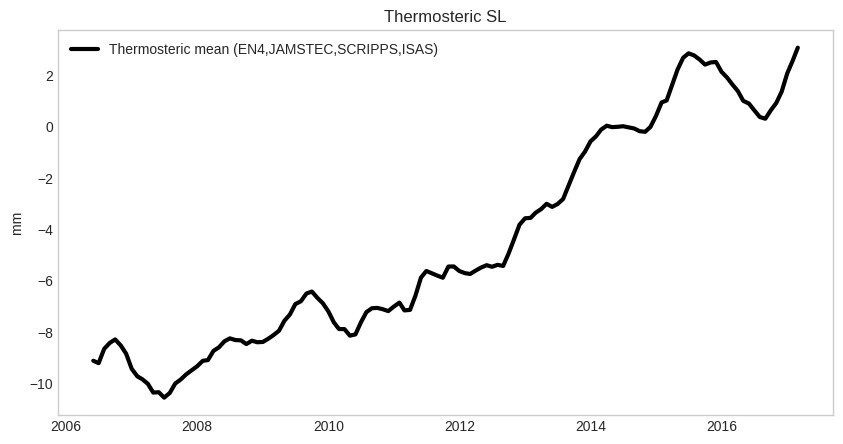

In [22]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(steric_mean.time,1e3*shz(steric_mean),'k',label='Thermosteric mean (EN4,JAMSTEC,SCRIPPS,ISAS)',linewidth=3)
ax.grid()

ax.set_ylabel('mm')
plt.legend()
plt.title('Thermosteric SL')

# Budget 
Let's add up, with GOMA first

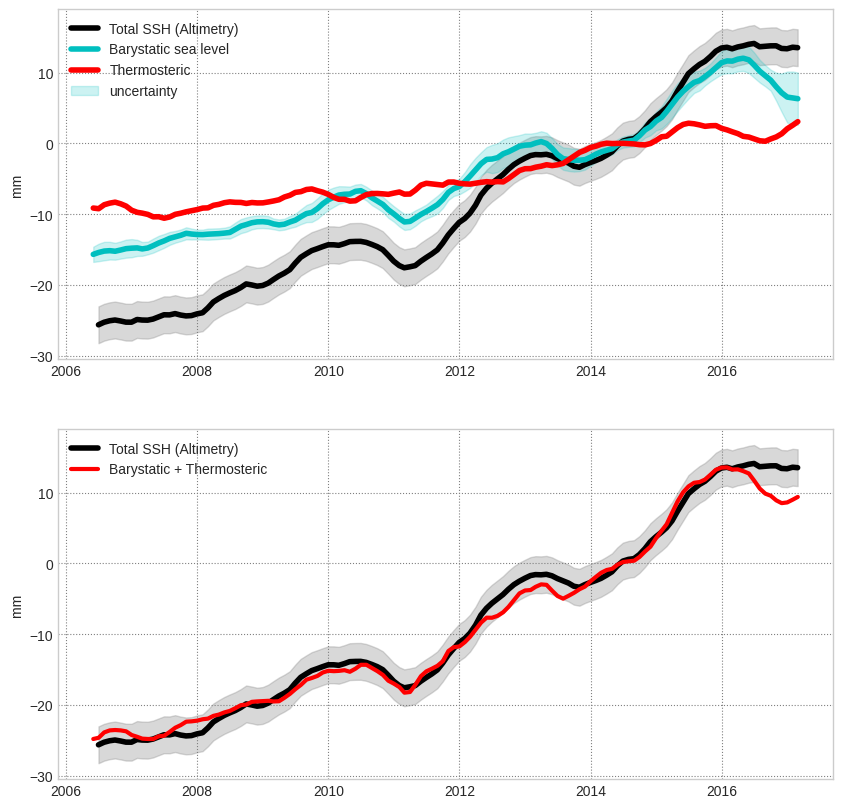

In [24]:
# interp thermosteric time array on goma one
sterici = steric_mean.interp(time=goma_mean.time)

fig,ax=plt.subplots(2,1,figsize=(10,10))
ax[0].plot(gmsl.time,1e3*shz(gmsl),'k',label='Total SSH (Altimetry)',linewidth=4)
ax[0].fill_between(gmsl.time,
                1e3*shz(gmsl)-gmsl_error,
                1e3*shz(gmsl)+gmsl_error,
                color='gray',alpha=0.3)

ax[0].plot(goma_mean.time,shz(goma_mean),'c',label='Barystatic sea level',linewidth=4)
ax[0].fill_between(goma_mean.time,
                shz(goma_mean) - 2*np.abs(goma_std.rolling(time=window,center=True).mean()),
                shz(goma_mean) + 2*np.abs(goma_std.rolling(time=window,center=True).mean()),
                color='c',alpha=0.2,label='uncertainty')


ax[0].plot(steric_mean.time,1e3*shz(steric_mean),'r',label='Thermosteric',linewidth=4)
ax[0].grid(linestyle=':',color='gray')
ax[0].set_ylabel('mm')
ax[0].legend()

ax[1].plot(gmsl.time,1e3*shz(gmsl),'k',label='Total SSH (Altimetry)',linewidth=4)
ax[1].fill_between(gmsl.time,
                1e3*shz(gmsl)-gmsl_error,
                1e3*shz(gmsl)+gmsl_error,
                color='gray',alpha=0.3)

c = (goma_mean+1e3*sterici)
    
ax[1].plot(c.time,shz(c),'red',label='Barystatic + Thermosteric',linewidth=3)
#ax[1].fill_between(c_shift.time,
#                  c_shift.rolling(time=window,center=True).mean()-2*goma_std,
#                  c_shift.rolling(time=window,center=True).mean()+2*goma_std, color='r',alpha=0.2)

ax[1].grid(linestyle=':',color='gray')
ax[1].set_ylabel('mm')
ax[1].legend()

#plt.savefig('figure_papier/GMSL_buget_alti-thermo-goma.png',dpi=300)

Now with TWS

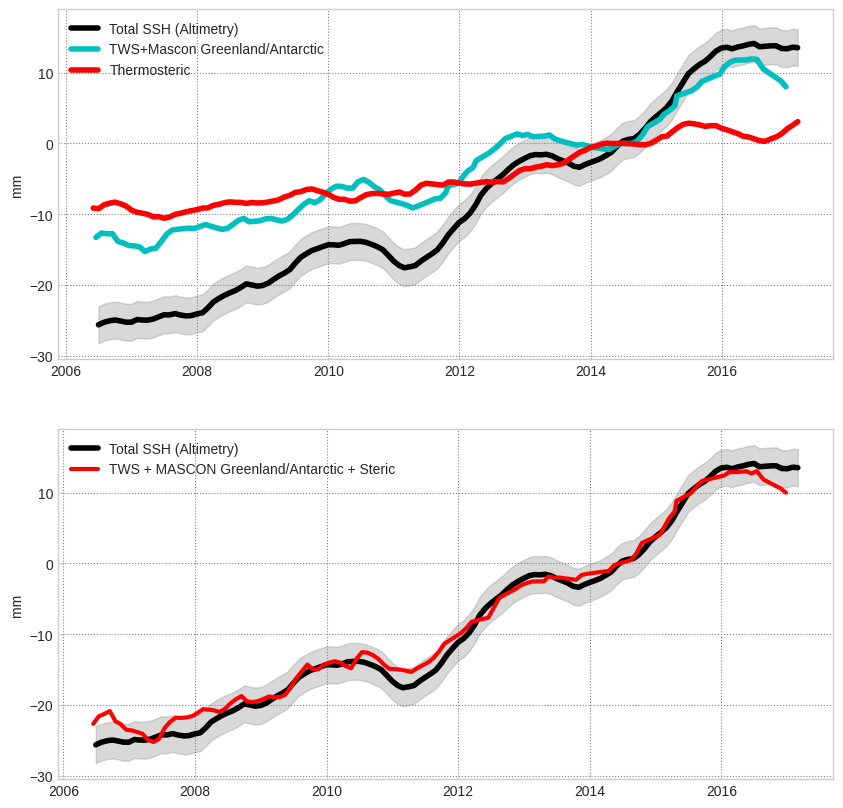

In [25]:
# Interp thermosteric time array
sterici = steric_mean.interp(time=grace_weighted.time)

fig,ax=plt.subplots(2,1,figsize=(10,10))
ax[0].plot(gmsl.time,1e3*shz(gmsl),'k',label='Total SSH (Altimetry)',linewidth=4)
ax[0].fill_between(gmsl.time,
                1e3*shz(gmsl)-gmsl_error,
                1e3*shz(gmsl)+gmsl_error,
                color='gray',alpha=0.3)

ax[0].plot(grace_weighted.time,(1e3*shz(grace_weighted).values + 10*shz(msc_jpl_weighted).values),
           'c',label='TWS+Mascon Greenland/Antarctic',linewidth=4)
ax[0].plot(steric_mean.time,1e3*shz(steric_mean),'r',label='Thermosteric',linewidth=4)
ax[0].grid(linestyle=':',color='gray')
ax[0].set_ylabel('mm')
ax[0].legend()

ax[1].plot(gmsl.time,1e3*shz(gmsl),'k',label='Total SSH (Altimetry)',linewidth=4)
ax[1].fill_between(gmsl.time,
                1e3*shz(gmsl)-gmsl_error,
                1e3*shz(gmsl)+gmsl_error,
                color='gray',alpha=0.3)

c = (1e3*grace_weighted+10*msc_jpl_weighted+1e3*sterici)
ax[1].plot(c.time,shz(c),'red',label='TWS + MASCON Greenland/Antarctic + Steric',linewidth=3)

ax[1].grid(linestyle=':',color='gray')
ax[1].set_ylabel('mm')
ax[1].legend()

# Per region
Let's decompose TWS by area, using salem (https://salem.readthedocs.io)

In [26]:
import salem
shdf = salem.read_shapefile('Continents/Continents.shp')
shdf['CONTINENT']

0           Africa
1             Asia
2        Australia
3    North America
4          Oceania
5    South America
6       Antarctica
7           Europe
Name: CONTINENT, dtype: object

In [27]:
ds_amsud1 = gland1.drop_dims('bounds').salem.roi(shape=shdf.loc[shdf['CONTINENT'] == 'South America'])
ds_amsud2 = gland2.drop_dims('bounds').salem.roi(shape=shdf.loc[shdf['CONTINENT'] == 'South America'])
ds_amsud3 = gland3.drop_dims('bounds').salem.roi(shape=shdf.loc[shdf['CONTINENT'] == 'South America'])
gtw_amsud1 = -1*(ds_amsud1['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load()
gtw_amsud2 = -1*(ds_amsud2['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load().interp(time=gtw_amsud1.time)
gtw_amsud3 = -1*(ds_amsud3['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load().interp(time=gtw_amsud1.time)
gtw_amsud = xr.DataArray(np.mean([gtw_amsud1,gtw_amsud2,gtw_amsud3],axis=0), dims=["time"],coords=dict(time=gtw_amsud1.time))

ds_amnord1 = gland1.drop_dims('bounds').salem.roi(shape=shdf.loc[shdf['CONTINENT'] == 'North America'])
ds_amnord2 = gland2.drop_dims('bounds').salem.roi(shape=shdf.loc[shdf['CONTINENT'] == 'North America'])
ds_amnord3 = gland3.drop_dims('bounds').salem.roi(shape=shdf.loc[shdf['CONTINENT'] == 'North America'])
gtw_amnord1 = -1*(ds_amnord1['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load()
gtw_amnord2 = -1*(ds_amnord2['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load().interp(time=gtw_amnord1.time)
gtw_amnord3 = -1*(ds_amnord3['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load().interp(time=gtw_amnord1.time)
gtw_amnord = xr.DataArray(np.mean([gtw_amnord1,gtw_amnord2,gtw_amnord3],axis=0), dims=["time"],coords=dict(time=gtw_amnord1.time))

ds_afr1 = gland1.drop_dims('bounds').salem.roi(shape=shdf.loc[shdf['CONTINENT'] == 'Africa'])
ds_afr2 = gland2.drop_dims('bounds').salem.roi(shape=shdf.loc[shdf['CONTINENT'] == 'Africa'])
ds_afr3 = gland3.drop_dims('bounds').salem.roi(shape=shdf.loc[shdf['CONTINENT'] == 'Africa'])
gtw_afr1 = -1*(ds_afr1['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load()
gtw_afr2 = -1*(ds_afr2['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load().interp(time=gtw_afr1.time)
gtw_afr3 = -1*(ds_afr3['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load().interp(time=gtw_afr1.time)
gtw_afr = xr.DataArray(np.mean([gtw_afr1,gtw_afr2,gtw_afr3],axis=0), dims=["time"],coords=dict(time=gtw_afr1.time))

ds_eur1 = gland1.drop_dims('bounds').salem.roi(shape=shdf.loc[shdf['CONTINENT'] == 'Europe'])
ds_eur2 = gland2.drop_dims('bounds').salem.roi(shape=shdf.loc[shdf['CONTINENT'] == 'Europe'])
ds_eur3 = gland3.drop_dims('bounds').salem.roi(shape=shdf.loc[shdf['CONTINENT'] == 'Europe'])
gtw_eur1 = -1*(ds_eur1['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load()
gtw_eur2 = -1*(ds_eur2['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load().interp(time=gtw_eur1.time)
gtw_eur3 = -1*(ds_eur3['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load().interp(time=gtw_eur1.time)
gtw_eur = xr.DataArray(np.mean([gtw_eur1,gtw_eur2,gtw_eur3],axis=0), dims=["time"],coords=dict(time=gtw_eur1.time))

ds_asia1 = gland1.drop_dims('bounds').salem.roi(shape=shdf.loc[(shdf['CONTINENT'] == 'Asia')|(shdf['CONTINENT'] == 'Oceania')|(shdf['CONTINENT'] == 'Australia')]) 
ds_asia2 = gland2.drop_dims('bounds').salem.roi(shape=shdf.loc[(shdf['CONTINENT'] == 'Asia')|(shdf['CONTINENT'] == 'Oceania')|(shdf['CONTINENT'] == 'Australia')]) 
ds_asia3 = gland3.drop_dims('bounds').salem.roi(shape=shdf.loc[(shdf['CONTINENT'] == 'Asia')|(shdf['CONTINENT'] == 'Oceania')|(shdf['CONTINENT'] == 'Australia')]) 
gtw_asia1 = -1*(ds_asia1['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load()
gtw_asia2 = -1*(ds_asia2['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load().interp(time=gtw_asia1.time)
gtw_asia3 = -1*(ds_asia3['lwe_thickness_scaled'] * weights_grace).sum(dim=('lat', 'lon')).load().interp(time=gtw_asia1.time)
gtw_asia = xr.DataArray(np.mean([gtw_asia1,gtw_asia2,gtw_asia3],axis=0), dims=["time"],coords=dict(time=gtw_asia1.time))

# poles
ds_pole = msc_jpl_pole
gtw_pole = -1*(ds_pole.lwe_thickness * weights_jpl).sum(dim=('lat', 'lon')).load()

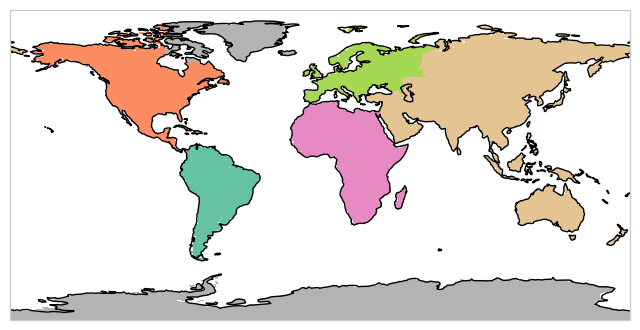

In [32]:
# MAPS
mcmap = plt.get_cmap('Set2',6)
colors1 = mcmap.colors

def tiny_map(xds,i,var='lwe_thickness_scaled'):    
    (0*xds[var].isel(time=0)+i).plot(ax=ax, cmap=mcmap, add_colorbar=False, vmin=0,vmax=6, transform=pr1)    
    
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(1,1,1,projection=pr1)
ax.coastlines()
ax.set_global()   
ax.set_title('')

tiny_map(ds_amsud1,0)
tiny_map(ds_amnord1,1)
tiny_map(ds_afr1,2)
tiny_map(ds_eur1,3)
tiny_map(ds_asia1,4)
tiny_map(ds_pole,5,var='lwe_thickness')
ax.set_title('')
#plt.savefig('figure_papier/regions.png',dpi=300)

Plot

In [53]:
def shzi(da,t=t3,window=8,ptime=np.arange('2006-03-15','2017-02-15',dtype='datetime64[M]')):
    return ((da.groupby('time.month')-da.groupby('time.month').mean()).interp(time=ptime).rolling(time=window,center=True).mean()) -\
           ((da.groupby('time.month')-da.groupby('time.month').mean()).interp(time=ptime).rolling(time=window,center=True).mean()).interp(time=t)

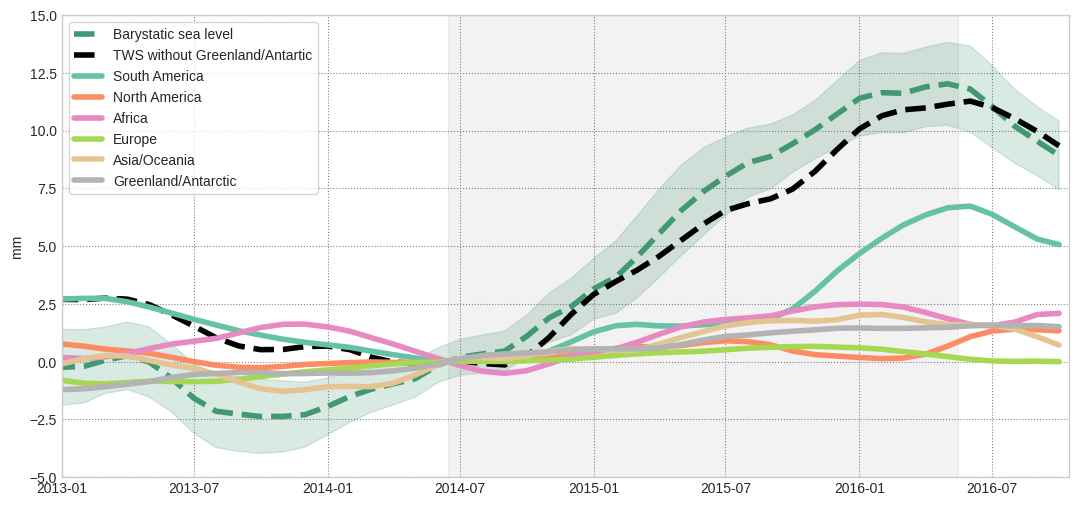

In [60]:
mcmap = plt.get_cmap('Set2',6)
colors1 = mcmap.colors
fig,ax = plt.subplots(figsize=(13,6))

imethod = 'linear'
window = 8
t3 = np.datetime64('2014-06-15')
t4 = np.datetime64('2016-05-15')

#reinterp on main regular time array
ptime = np.arange('2006-03-15','2017-02-15',dtype='datetime64[M]')

ax.plot(shzi(goma_mean).time,shzi(goma_mean),'--',color='#419873',linewidth=4,label='Barystatic sea level')

ax.fill_between(ptime,
                shzi(goma_mean) - 2*np.abs(goma_std.rolling(time=window,center=True).mean()),
                shzi(goma_mean) + 2*np.abs(goma_std.rolling(time=window,center=True).mean()), color='#419873',alpha=0.2)

ax.plot(shzi(grace_weighted).time,1e3*shzi(grace_weighted),'--k',label='TWS without Greenland/Antartic',linewidth=4)
#ax.plot(shzi(grace_weighted).time,1e3*shzi(grace_weighted).values + 10*shzi(msc_jpl_weighted).values,'k',label='TWS with GA',linewidth=4)
ax.plot(shzi(gtw_amsud).time,1e3*shzi(gtw_amsud),color=colors1[0,:],label='South America',linewidth=4)
ax.plot(shzi(gtw_amnord).time,1e3*shzi(gtw_amnord),color=colors1[1,:],label='North America',linewidth=4)
ax.plot(shzi(gtw_afr).time,1e3*shzi(gtw_afr),color=colors1[2,:],label='Africa',linewidth=4)
ax.plot(shzi(gtw_eur).time,1e3*shzi(gtw_eur),color=colors1[3,:],label='Europe',linewidth=4)
ax.plot(shzi(gtw_asia).time,1e3*shzi(gtw_asia),color=colors1[4,:],label='Asia/Oceania',linewidth=4)
ax.plot(shzi(gtw_pole).time,10*shzi(gtw_pole),color=colors1[5,:],label='Greenland/Antarctic',linewidth=4)

# SUM
#cx = (gtw_amsud + gtw_amnord + gtw_afr + gtw_eur + gtw_asia)
#ax.plot(shzi(cx).time,1e3*shzi(cx),'-',color='pink',linewidth=3,label='sum',zorder=11)

ax.grid(linestyle=':',color='gray')
ax.set_facecolor('w')
ax.set_ylabel('mm')
ax.set_xlim([np.datetime64('2013-01-01'),np.datetime64('2016-10-15')])
plt.ylim([-5,15])

plt.legend(frameon=True, facecolor='white')

ax.axvspan(t3, t4, alpha=0.1, color='grey')

#plt.savefig('figure_papier/mass_esl_budget_2014-2016.png',dpi=300)

In [33]:
ysa = (gmsl.groupby("time.month") - gmsl.groupby("time.month").mean()).rolling(time=window_gmsl,center=True).mean()
sa=1e3*(ysa.interp(time=t4,method=imethod)-ysa.interp(time=t3,method=imethod)).values
print('Altimetry : ',"{:.1f}".format(sa),'mm of global sealevel change\n')

#ys0b = ((gtw+gtw_pole).groupby("time.month") - (gtw+gtw_pole).groupby("time.month").mean()).rolling(time=window,center=True).mean() 
ys0 = (goma_mean.groupby("time.month") - goma_mean.groupby("time.month").mean()).rolling(time=window,center=True).mean() 
s0=(ys0.interp(time=t4,method=imethod)-ys0.interp(time=t3,method=imethod)).values
print('Grace\t',"{:.1f}".format(s0),'mm','\t',"{:.1f}".format(100*s0/sa),'% explained by ocean mass change')

ys1 = (gtw_amsud.groupby("time.month") - gtw_amsud.groupby("time.month").mean()).rolling(time=window,center=True).mean()
s1=1e3*(ys1.interp(time=t4,method=imethod)-ys1.interp(time=t3,method=imethod)).values
print('--> \t',"{:.1f}".format(s1),'mm \t',"{:.1f}".format(100*s1/s0),'% of ocean mass explained by Amsud')

ys2 = (gtw_amnord.groupby("time.month") - gtw_amnord.groupby("time.month").mean()).rolling(time=window,center=True).mean()
s2=1e3*(ys2.interp(time=t4,method=imethod)-ys2.interp(time=t3,method=imethod)).values
print('--> \t',"{:.1f}".format(s2),'mm \t',"{:.1f}".format(100*s2/s0),'% of ocean mass explained by AmNord')

ys3 = (gtw_afr.groupby("time.month") - gtw_afr.groupby("time.month").mean()).rolling(time=window,center=True).mean()
s3=1e3*(ys3.interp(time=t4,method=imethod)-ys3.interp(time=t3,method=imethod)).values
print('--> \t',"{:.1f}".format(s3),'mm \t',"{:.1f}".format(100*s3/s0),'% of ocean mass explained by Africa')

ys4 = (gtw_eur.groupby("time.month") - gtw_eur.groupby("time.month").mean()).rolling(time=window,center=True).mean()
s4=1e3*(ys4.interp(time=t4,method=imethod)-ys4.interp(time=t3,method=imethod)).values
print('--> \t',"{:.1f}".format(s4),'mm \t',"{:.1f}".format(100*s4/s0),'% of ocean mass explained by Europe')

ys5 = (gtw_asia.groupby("time.month") - gtw_asia.groupby("time.month").mean()).rolling(time=window,center=True).mean()
s5=1e3*(ys5.interp(time=t4,method=imethod)-ys5.interp(time=t3,method=imethod)).values
print('--> \t',"{:.1f}".format(s5),'mm \t',"{:.1f}".format(100*s5/s0),'% of ocean mass explained by Asia/Australia')

ys6 = (gtw_pole.groupby("time.month") - gtw_pole.groupby("time.month").mean()).rolling(time=window,center=True).mean()
s6=10*(ys6.interp(time=t4,method=imethod)-ys6.interp(time=t3,method=imethod)).values
print('--> \t',"{:.1f}".format(s6),'mm \t',"{:.1f}".format(100*s6/s0),'% of ocean mass explained by Greenland/Antarctic')

print("{:.1f}".format(s1+s2+s3+s4+s5+s6),"mm \t","{:.1f}".format(100*(s1+s2+s3+s4+s5+s6)/s0)," %")

Altimetry :  15.0 mm of global sealevel change

Grace	 11.9 mm 	 79.7 % explained by ocean mass change
--> 	 6.2 mm 	 51.6 % of ocean mass explained by Amsud
--> 	 0.6 mm 	 5.0 % of ocean mass explained by AmNord
--> 	 1.8 mm 	 14.8 % of ocean mass explained by Africa
--> 	 0.3 mm 	 2.2 % of ocean mass explained by Europe
--> 	 1.5 mm 	 12.4 % of ocean mass explained by Asia/Australia
--> 	 1.4 mm 	 11.9 % of ocean mass explained by Greenland/Antarctic
11.7 mm 	 97.8  %


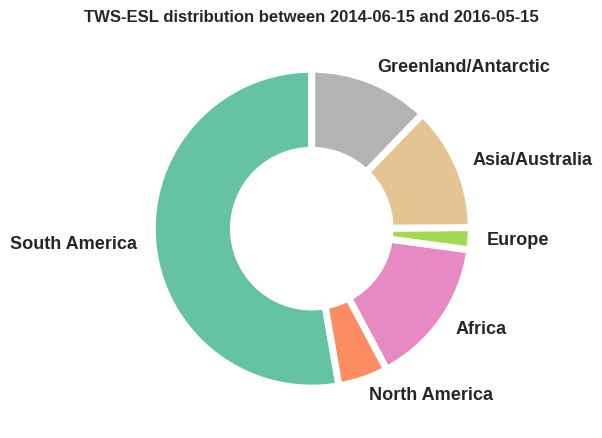

In [34]:
### Pie chart
labels = ['South America', 'North America', 'Africa', 'Europe', 'Asia/Australia', 'Greenland/Antarctic']
sizes = [s1, s2, s3, s4, s5, s6]
wedgeprops={"edgecolor":"w",'linewidth': 5}
textprops={"fontweight":"bold","fontsize":13}

def absolute_value(val):
    a = sizes[ np.abs(sizes - val/100.*np.array(sizes).sum()).argmin() ]        
    return "{:.1f}".format(a)+" mm"

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(sizes, colors = colors1, labels=labels, startangle=90, wedgeprops=wedgeprops, textprops=textprops, normalize=True)
centre_circle = plt.Circle((0,0),0.50,fc='white',color='w',linewidth=3)
ax1.add_artist(centre_circle)# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.title('TWS-ESL distribution between '+str(t3)+' and '+str(t4),fontweight='bold')
#plt.savefig('figure_papier/pie_spatial_distribution.png',dpi=300)

# Let's look at the TWS from a basins level in amsud

http://hydro.iis.u-tokyo.ac.jp/~taikan/TRIPDATA/TRIPDATA.html  
I'm using the TRIP mask : http://hydro.iis.u-tokyo.ac.jp/~taikan/TRIPDATA/Data/trip_0.5x0.5.nc  
and names associated to basin index : http://hydro.iis.u-tokyo.ac.jp/~taikan/TRIPDATA/Data/rivnum05.txt

In [35]:
trip = xr.open_dataset('trip_0.5x0.5.nc')
names = pd.read_csv('rivnames2.txt',delimiter=" ")
#REGRID TRIP TO 1° TO MATCH TWS DATA
trip = trip.interp(lon=gland1.lon.values,lat=gland1.lat.values,method = 'nearest')
#ASSIGN BASIN IN GRACE DS
gland1['basin'] = trip['rbasin']
gland2['basin'] = trip['rbasin']
gland3['basin'] = trip['rbasin']

## Contribution per basins

In [36]:
gland1.load()
gland2.load()
gland3.load()

<xarray.Dataset>
Dimensions:               (bounds: 2, lat: 180, lon: 360, time: 119)
Coordinates:
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time                  (time) datetime64[ns] 2006-02-15 ... 2017-05-12T12:...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness         (time, lat, lon) float64 -0.007251 -0.007245 ... nan
    uncertainty           (time, lat, lon) float64 0.01572 0.01572 ... nan nan
    lat_bounds            (time, lat, bounds) float64 -90.0 -89.0 ... 89.0 90.0
    lon_bounds            (time, lon, bounds) float64 180.0 181.0 ... 180.0
    time_bounds           (time, bounds) datetime64[ns] 2006-02-01 ... 2017-0...
    lwe_thickness_scaled  (time, lat, lon) float64 nan nan nan ... nan nan nan
    basin                 (lat, lon) float64 2.064e+03 2.413e+03 ... nan nan
Attributes:
    Conventions:                CF-1.6
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    title:                      GRACE-FO Water-Equivalent-Thickness Surface-M...
    id:                         TELND-3NJ64
    summary:                    Gridded surface mass anomalies, derived from ...
    processing_level:           3
    product_version_Level3:     LND_sw06_k20_G300_GCSAL_v04
    creator_name:               GRACE Science Data System NASA/JPL
    creator_email:              grace@jpl.nasa.gov
    creator_url:                https://www.grace.jpl.nasa.gov
    date_created:               2021-04-28T09:58:11
    date_issued:                2021-04-27T17:48:31
    acknowledgement:            GRACE is a joint mission of NASA (USA) and DL...
    license:                    https://science.nasa.gov/earth-science/earth-...
    product_version:            RL06
    time_epoch:                 2002-01-01T00:00:00
    static_field_time_epoch:    2008-01-01T12:00:00
    time_mean_removed:          2005-01-01 to 2010-12-31
    filter_type:                Gauss 300 km
    postprocess_1:              Water density used to convert to equivalent w...
    postprocess_2:              Background model added back: 
    postprocess_3:              Decorrelation ('de-stripe') filter: [Swenson ...
    postprocess_4:              Ellipsoidal Correction has been applied [Ghob...
    GIA_removed:                Peltier (Ice-6G_D (updated; 06/2017!))
    geocenter_correction:       Corrected; after [Sun et al., 2016, doi:10.10...
    C_20_substitution:          [Loomis et al., 2019, Geophys. Res. Lett., do...
    journal_reference:          [Landerer F.W. and S. C. Swenson, Accuracy of...
    project:                    NASA Gravity Recovery And Climate Experiment ...
    program:                    NASA Earth Science System Pathfinder
    keywords:                   Surface Mass, Mass Transport, Terrestrial Wat...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    institution:                NASA/JPL
    naming_authority:           org.doi.dx
    history:                    Level-3 processing at JPL with Original solut...
    source:                     An inversion using GRACE-A and GRACE-B measur...
    platform:                   GRACE-A, GRACE-B
    platform_vocabulary:        NASA Global Change Master Directory platform ...
    instrument:                 GRACE-A ACC, GRACE-A GPS, GRACE-A KBR, GRACE-...
    instrument_vocabulary:      NASA Global Change Master Directory instrumen...
    references:                 Cooley, Landerer (2019), GRACE/GRACE-FO Level...
    creator_type:               group
    creator_institution:        NASA/JPL
    publisher_name:             Physical Oceanography Distributed Active Arch...
    publisher_email:            podaac@jpl.nasa.gov
    publisher_url:              https://podaac.jpl.nasa.gov
    publisher_type:             group
    publisher_institution:      NASA/JPL
    time_coverage_start:        2002-

In [37]:
# calculate TSW-ESL for N major world basins
#sel_basins = np.unique(dsg['basin'].where((dsg['lat']<=15) & (dsg['lat']>=-56) & (dsg['lon']<=-30),drop=False)).astype(int)[:100]
sel_basins = np.array([1,24,23,61,40,112,232,74,243,138,368,158,417,385,296,59,67,66,5])
sel_tws_basins = np.zeros(len(sel_basins),dtype='float64')

for k in range(len(sel_basins)):   
    # TWS for one basin
    sdsg1 = gland1.where(gland1['basin']==sel_basins[k],drop=False)
    sdsg2 = gland2.where(gland2['basin']==sel_basins[k],drop=False)
    sdsg3 = gland3.where(gland3['basin']==sel_basins[k],drop=False)
    
    # Mass transfer from land to ocean (-1)
    sgtw1 = -1*(sdsg1.lwe_thickness_scaled * weights_grace).sum(dim=('lat', 'lon')).load()    
    sgtw2 = -1*(sdsg2.lwe_thickness_scaled * weights_grace).sum(dim=('lat', 'lon')).load()    
    sgtw3 = -1*(sdsg3.lwe_thickness_scaled * weights_grace).sum(dim=('lat', 'lon')).load()    
    # remove clim & smooth
    sgtw1 = (sgtw1.groupby("time.month") - sgtw1.groupby("time.month").mean('time')).rolling(time=window,center=True).mean()
    sgtw2 = (sgtw2.groupby("time.month") - sgtw2.groupby("time.month").mean('time')).rolling(time=window,center=True).mean()
    sgtw3 = (sgtw3.groupby("time.month") - sgtw3.groupby("time.month").mean('time')).rolling(time=window,center=True).mean()
    # calculate delta tws-esl for the period
    sel_tws_basins[k] = 1e3*np.mean([(sgtw1.interp(time=t4) - sgtw1.interp(time=t3)),
                                     (sgtw2.interp(time=t4) - sgtw2.interp(time=t3)),
                                     (sgtw3.interp(time=t4) - sgtw3.interp(time=t3))])                                    

In [38]:
# sort
y = sel_tws_basins.flatten()
l = names['river_basin_name'][sel_basins.flatten()-1]
x = sel_basins 
ys,ls,xs = zip(*sorted(zip(y, l, x),reverse=True))

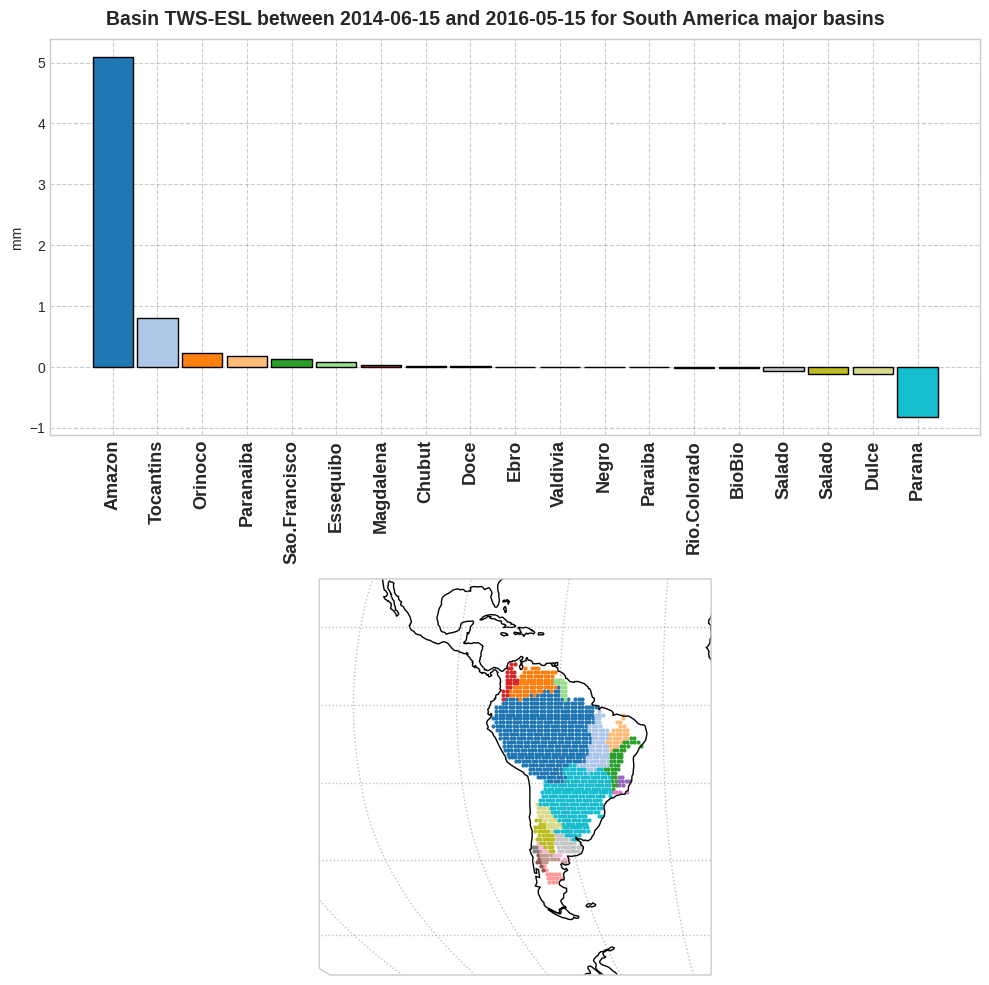

In [39]:
#colors
colors2 = plt.get_cmap('tab20',20).colors

# combine them n times to build a new colormap
tcolors = np.vstack((colors2))

fig = plt.figure(figsize=(10,10))
plt.suptitle('Basin TWS-ESL between '+str(t3)+' and '+str(t4)+' for South America major basins',fontweight='bold',fontsize=14)
axA = fig.add_subplot(2,1,1)                      
_ = axA.bar(range(len(ys)),ys,tick_label=ls, align='center', width=0.90, edgecolor='k',color=tcolors)
_ = axA.set_xticklabels(axA.get_xticklabels(),rotation=90)
axA.grid(linestyle='--',color='gray',alpha=0.4)
#_ = axA.set_ylim([-2.5,6.5])
axA.set_ylabel('mm')
# apply offset transform to all x ticklabels.
for label in axA.xaxis.get_majorticklabels():
    #label.set_transform(label.get_transform() + matplotlib.transforms.ScaledTranslation(0, 1.5, fig.dpi_scale_trans))
    label.set_fontweight('bold')
    label.set_fontsize(13) 

ax0 = fig.add_subplot(2,1,2,projection=pr2)
for i in range(len(ys)):
    sdsg0 = gland1.where(gland1['basin']==xs[i],drop=True)
    #ax0.pcolor(sdsg0.lon,sdsg0.lat,sdsg0.basin,color=tcolors[i,:], transform=pr1)
    sdsg0.plot.scatter(x='lon',y='lat',hue='basin',hue_style='discrete',s=4,color=tcolors[i,:],transform=pr1,add_guide=False,ax=ax0)
ax0.set_extent([-130,-20,-60,20])
#ax.add_feature(cfeature.LAND, edgecolor='black', facecolor="none", linewidth=1)
ax0.coastlines()
ax0.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle=':', draw_labels=False)

plt.tight_layout()
#plt.savefig('figure_papier/tws-esl_amsud-2014-2016.png',dpi=300)